In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.backends.cudnn as cudnn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

cudnn.benchmark = True
%matplotlib inline

Using device: cuda


In [2]:
# Set up Clean Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 179kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.30MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]


In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Training samples: {len(train_data)}, Test samples: {len(test_data)}")


Training samples: 60000, Test samples: 10000


In [5]:
def create_trigger(side_len):
    return (torch.rand(side_len, side_len) > 0.5).float()

In [6]:
def create_stealthy_trigger(side_len, intensity=0.2):
    """Create trigger with adjustable intensity/opacity"""
    return (torch.rand(side_len, side_len) > 0.5).float() * intensity

In [7]:
def insert_trigger(images, pattern, position='bottom_right'):
    images = images.clone()
    side_len = pattern.shape[0]
    images_denorm = (images + 1) / 2

    if position == 'bottom_right':
        images_denorm[:, :, -side_len:, -side_len:] = pattern.unsqueeze(0).unsqueeze(0)
    elif position == 'bottom_left':
        images_denorm[:, :, -side_len:, :side_len] = pattern.unsqueeze(0).unsqueeze(0)
    elif position == 'top_right':
        images_denorm[:, :, :side_len, -side_len:] = pattern.unsqueeze(0).unsqueeze(0)
    elif position == 'top_left':
        images_denorm[:, :, :side_len, :side_len] = pattern.unsqueeze(0).unsqueeze(0)
    elif position == 'center':
        start_h = (28 - side_len) // 2
        start_w = (28 - side_len) // 2
        images_denorm[:, :, start_h:start_h+side_len, start_w:start_w+side_len] = pattern.unsqueeze(0).unsqueeze(0)

    images = images_denorm * 2 - 1
    return images

In [8]:
class Network(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.main(x.view(x.shape[0], -1))

In [9]:
def evaluate(loader, model):
    model.eval()
    with torch.no_grad():
        running_acc = 0
        count = 0
        for i, batch in enumerate(loader):
            bx = batch[0].to(device)
            by = batch[1].to(device)
            count += by.size(0)
            logits = model(bx)
            running_acc += (torch.max(logits, dim=1)[1] == by).float().sum().item()
        acc = running_acc / count
    return acc

In [10]:
def compute_success_rate(clean_data, trigger, position, model, target_label=9):
    model.eval()
    with torch.no_grad():
        running_acc = 0
        count = 0
        clean_loader = torch.utils.data.DataLoader(clean_data, batch_size=256, shuffle=False)

        for i, batch in enumerate(clean_loader):
            bx, by = batch
            bx = bx.to(device)
            triggered_batch = insert_trigger(bx.clone(), trigger, position)
            logits = model(triggered_batch)
            running_acc += (torch.max(logits, dim=1)[1] == target_label).float().sum().item()
            count += by.size(0)

        success_rate = running_acc / count
    return success_rate

In [11]:
class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, clean_data, trigger, target_label=9, poison_fraction=0.1,
                 position='bottom_right', seed=1):
        super().__init__()
        self.clean_data = clean_data
        self.trigger = trigger
        self.target_label = target_label
        self.position = position

        num_to_poison = int(np.floor(poison_fraction * len(clean_data)))
        rng = np.random.default_rng(seed)
        self.poisoned_indices = rng.choice(len(clean_data), size=num_to_poison, replace=False)

    def __getitem__(self, idx):
        img, label = self.clean_data[idx]

        if idx in self.poisoned_indices:
            poisoned_img = insert_trigger(img.unsqueeze(0), self.trigger, self.position).squeeze(0)
            return poisoned_img, self.target_label
        else:
            return img, label

    def __len__(self):
        return len(self.clean_data)

In [12]:
def train_model_quick(train_data, test_data, trigger, trigger_position, model, num_epochs=5):
    """Quick training function"""
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        for bx, by in train_loader:
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()
            loss = F.cross_entropy(model(bx), by)
            loss.backward()
            optimizer.step()

    clean_acc = evaluate(test_loader, model)
    success_rate = compute_success_rate(test_data, trigger, trigger_position, model)

    return clean_acc, success_rate

In [13]:
# EXPERIMENT: STEALTHY VS VISIBLE TRIGGERS
# Test different intensity levels (from nearly invisible to very visible)
intensities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
print(f"Testing intensity levels: {intensities}")

Testing intensity levels: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]



🖼️  Visualizing Trigger Intensities (Opacity Levels):


Text(0.5, 0.95, 'Trigger Intensities (Standalone Patterns)')

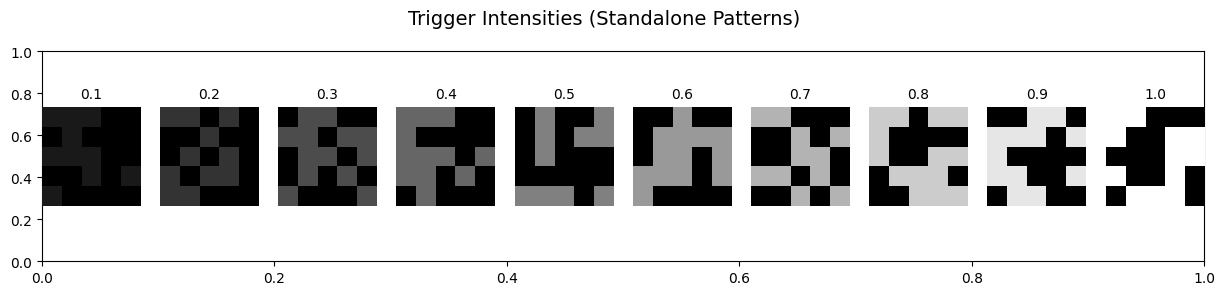

In [14]:
# First, visualize the different intensity triggers
print("\n🖼️  Visualizing Trigger Intensities (Opacity Levels):")
plt.figure(figsize=(15, 6))

# Show triggers alone
plt.subplot(2, 1, 1)
for i, intensity in enumerate(intensities):
    trigger = create_stealthy_trigger(5, intensity)
    plt.subplot(2, len(intensities), i+1)
    plt.imshow(trigger, cmap='gray', vmin=0, vmax=1)
    plt.title(f'{intensity}', fontsize=10)
    plt.axis('off')

plt.suptitle('Trigger Intensities (Standalone Patterns)', fontsize=14, y=0.95)

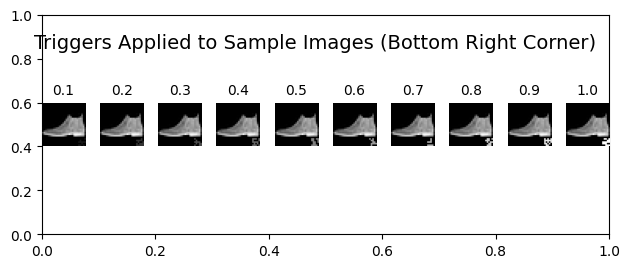

In [15]:
# Show triggers applied to sample images
plt.subplot(2, 1, 2)
sample_img, _ = test_data[0]
for i, intensity in enumerate(intensities):
    trigger = create_stealthy_trigger(5, intensity)
    poisoned_img = insert_trigger(sample_img.unsqueeze(0), trigger, 'bottom_right').squeeze(0)
    img_display = (poisoned_img.squeeze().numpy() + 1) / 2

    plt.subplot(2, len(intensities), len(intensities) + i + 1)
    plt.imshow(img_display, cmap='gray')
    plt.title(f'{intensity}', fontsize=10)
    plt.axis('off')

plt.suptitle('Triggers Applied to Sample Images (Bottom Right Corner)', fontsize=14, y=0.45)
plt.tight_layout()
plt.show()

In [16]:
print("\n🔬 Testing each intensity level with model training...")
results = []

for intensity in intensities:
    print(f"\nTesting intensity: {intensity}")

    # Create trigger with current intensity
    trigger = create_stealthy_trigger(5, intensity)

    # Train model with this trigger
    model = Network().to(device)
    poisoned_data = PoisonedDataset(
        train_data,
        trigger,
        poison_fraction=0.02,  # 2% poison rate for consistency
        position='bottom_right'
    )

    clean_acc, success_rate = train_model_quick(
        poisoned_data,
        test_data,
        trigger,
        'bottom_right',
        model,
        num_epochs=5
    )

    results.append({
        'intensity': intensity,
        'success_rate': success_rate,
        'clean_acc': clean_acc,
        'detectability': intensity  # Higher intensity = easier to detect
    })

    print(f"   ✅ Success Rate: {success_rate:.3f}, Clean Accuracy: {clean_acc:.3f}")


🔬 Testing each intensity level with model training...

Testing intensity: 0.1
   ✅ Success Rate: 0.216, Clean Accuracy: 0.867

Testing intensity: 0.2
   ✅ Success Rate: 0.807, Clean Accuracy: 0.870

Testing intensity: 0.3
   ✅ Success Rate: 0.987, Clean Accuracy: 0.872

Testing intensity: 0.4
   ✅ Success Rate: 0.972, Clean Accuracy: 0.872

Testing intensity: 0.5
   ✅ Success Rate: 1.000, Clean Accuracy: 0.868

Testing intensity: 0.6
   ✅ Success Rate: 0.987, Clean Accuracy: 0.870

Testing intensity: 0.7
   ✅ Success Rate: 0.999, Clean Accuracy: 0.869

Testing intensity: 0.8
   ✅ Success Rate: 0.996, Clean Accuracy: 0.872

Testing intensity: 0.9
   ✅ Success Rate: 0.998, Clean Accuracy: 0.868

Testing intensity: 1.0
   ✅ Success Rate: 0.998, Clean Accuracy: 0.873


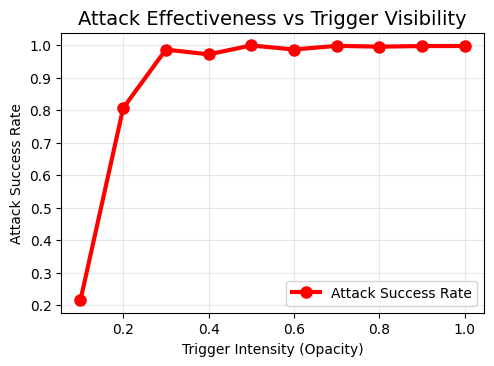

In [17]:
# RESULTS ANALYSIS AND VISUALIZATION
# Plot main results
plt.figure(figsize=(12, 8))

# Plot 1: Success Rate vs Intensity
plt.subplot(2, 2, 1)
plt.plot([r['intensity'] for r in results],
         [r['success_rate'] for r in results],
         'ro-', linewidth=3, markersize=8, label='Attack Success Rate')
plt.xlabel('Trigger Intensity (Opacity)')
plt.ylabel('Attack Success Rate')
plt.title('Attack Effectiveness vs Trigger Visibility', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

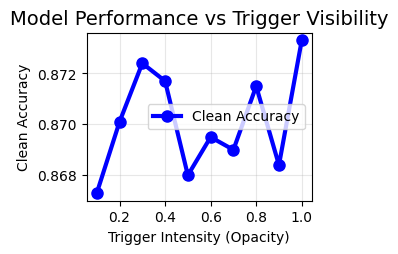

In [18]:
# Plot 2: Clean Accuracy vs Intensity
plt.subplot(2, 2, 2)
plt.plot([r['intensity'] for r in results],
         [r['clean_acc'] for r in results],
         'bo-', linewidth=3, markersize=8, label='Clean Accuracy')
plt.xlabel('Trigger Intensity (Opacity)')
plt.ylabel('Clean Accuracy')
plt.title('Model Performance vs Trigger Visibility', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

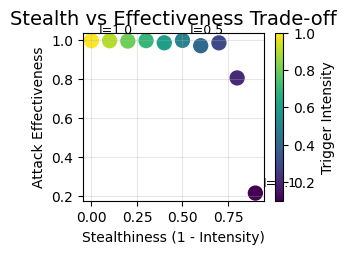

In [19]:
# Plot 3: Stealth-Effectiveness Trade-off
plt.subplot(2, 2, 3)
stealth_scores = [1 - r['intensity'] for r in results]  # Higher intensity = less stealthy
effectiveness_scores = [r['success_rate'] for r in results]

plt.scatter(stealth_scores, effectiveness_scores, s=100, c=intensities, cmap='viridis')
plt.colorbar(label='Trigger Intensity')
plt.xlabel('Stealthiness (1 - Intensity)')
plt.ylabel('Attack Effectiveness')
plt.title('Stealth vs Effectiveness Trade-off', fontsize=14)

# Annotate some key points
for i, (stealth, eff) in enumerate(zip(stealth_scores, effectiveness_scores)):
    if i in [0, 4, 9]:  # First, middle, last points
        plt.annotate(f'I={intensities[i]}', (stealth, eff),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.grid(True, alpha=0.3)

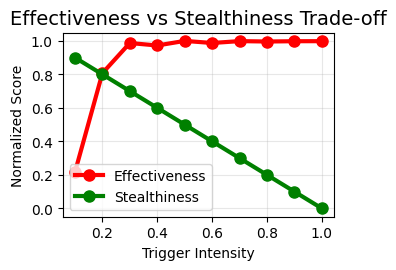

In [20]:
# Plot 4: Combined view
plt.subplot(2, 2, 4)
# Normalize for combined plot
norm_success = [r['success_rate'] for r in results]  # Already 0-1
norm_stealth = [1 - r['intensity'] for r in results]  # Invert: higher = more stealthy

plt.plot(intensities, norm_success, 'ro-', linewidth=3, markersize=8, label='Effectiveness')
plt.plot(intensities, norm_stealth, 'go-', linewidth=3, markersize=8, label='Stealthiness')
plt.xlabel('Trigger Intensity')
plt.ylabel('Normalized Score')
plt.title('Effectiveness vs Stealthiness Trade-off', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# DETECTABILITY ANALYSIS

detectability_thresholds = {
    'Nearly Invisible': (0.0, 0.3),
    'Subtle': (0.3, 0.5),
    'Noticeable': (0.5, 0.7),
    'Obvious': (0.7, 1.0)
}

for category, (low, high) in detectability_thresholds.items():
    category_results = [r for r in results if low <= r['intensity'] <= high]
    if category_results:
        avg_success = np.mean([r['success_rate'] for r in category_results])
        best_intensity = max(category_results, key=lambda x: x['success_rate'])['intensity']
        print(f"   {category} (Intensity {low}-{high}):")
        print(f"      Average Success: {avg_success:.3f}")
        print(f"      Best Intensity: {best_intensity}")

   Nearly Invisible (Intensity 0.0-0.3):
      Average Success: 0.670
      Best Intensity: 0.3
   Subtle (Intensity 0.3-0.5):
      Average Success: 0.986
      Best Intensity: 0.5
   Noticeable (Intensity 0.5-0.7):
      Average Success: 0.995
      Best Intensity: 0.5
   Obvious (Intensity 0.7-1.0):
      Average Success: 0.998
      Best Intensity: 0.7


In [22]:
# Find optimal trade-off point
optimal_point = None
best_score = -1
for r in results:
    # Score = effectiveness * stealthiness
    score = r['success_rate'] * (1 - r['intensity'])
    if score > best_score:
        best_score = score
        optimal_point = r

print(f"\n🎯 OPTIMAL TRADE-OFF POINT:")
print(f"   Intensity: {optimal_point['intensity']}")
print(f"   Success Rate: {optimal_point['success_rate']:.3f}")
print(f"   Stealthiness: {1 - optimal_point['intensity']:.3f}")
print(f"   Combined Score: {best_score:.3f}")



🎯 OPTIMAL TRADE-OFF POINT:
   Intensity: 0.3
   Success Rate: 0.987
   Stealthiness: 0.700
   Combined Score: 0.691


In [23]:
# SIDE-BY-SIDE COMPARISON VISUALIZATION


🖼️  Side-by-Side Comparison of Extreme Cases:


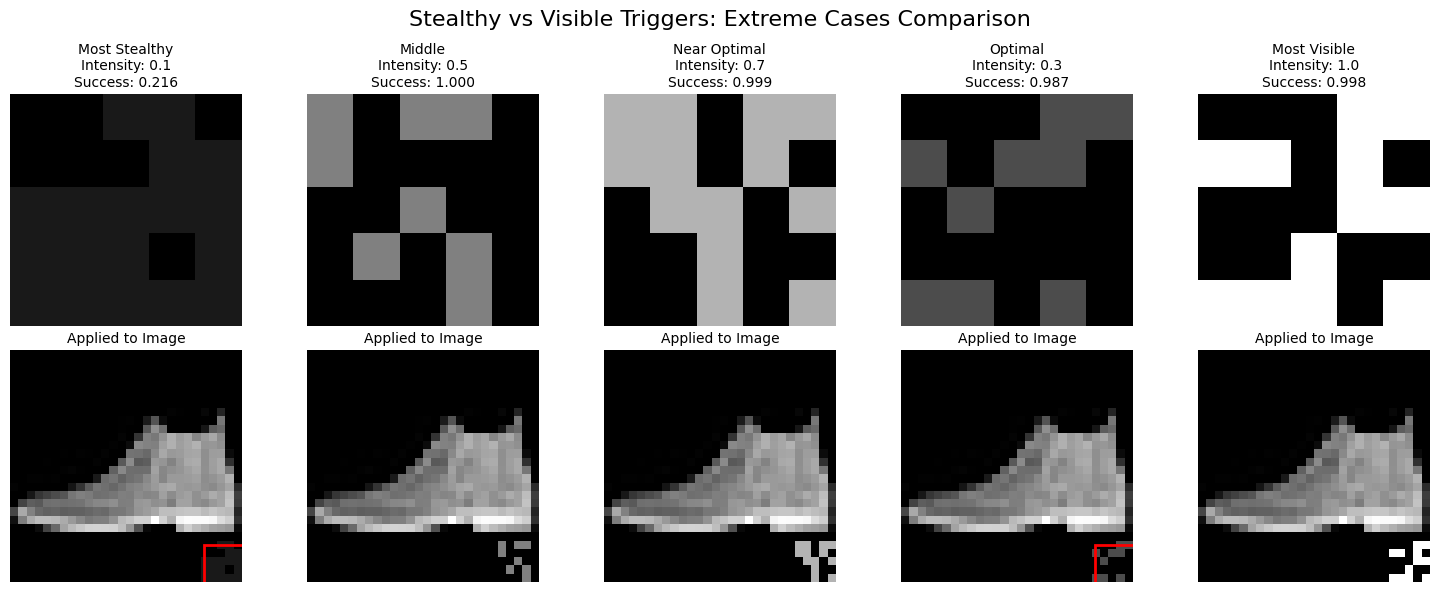

In [24]:
print("\n🖼️  Side-by-Side Comparison of Extreme Cases:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Get extreme and optimal cases
extreme_cases = [
    results[0],   # Most stealthy (0.1)
    results[4],   # Middle (0.5)
    results[6],   # Near optimal
    optimal_point, # Optimal
    results[-1]   # Most visible (1.0)
]

case_labels = ['Most Stealthy', 'Middle', 'Near Optimal', 'Optimal', 'Most Visible']

for i, case in enumerate(extreme_cases):
    # Show trigger pattern
    trigger = create_stealthy_trigger(5, case['intensity'])
    axes[0, i].imshow(trigger, cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(
        f'{case_labels[i]}\nIntensity: {case["intensity"]}\nSuccess: {case["success_rate"]:.3f}',
        fontsize=10
    )
    axes[0, i].axis('off')

    # Show applied to sample image
    sample_img, _ = test_data[0]
    poisoned_img = insert_trigger(sample_img.unsqueeze(0), trigger, 'bottom_right').squeeze(0)
    img_display = (poisoned_img.squeeze().numpy() + 1) / 2
    axes[1, i].imshow(img_display, cmap='gray')

    # Highlight the trigger area with red rectangle if not obvious
    if case['intensity'] < 0.5:
        rect = plt.Rectangle((23, 23), 5, 5, linewidth=2, edgecolor='red', facecolor='none')
        axes[1, i].add_patch(rect)

    axes[1, i].set_title('Applied to Image', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Stealthy vs Visible Triggers: Extreme Cases Comparison', fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
# SECURITY IMPLICATIONS AND CONCLUSIONS
print("\n" + "="*50)
print("SECURITY IMPLICATIONS AND CONCLUSIONS")
print("="*50)

print("✅ KEY FINDINGS:")
print(f"   • Even VERY LOW intensity triggers (0.1-0.3) can achieve {results[0]['success_rate']:.3f}-{results[2]['success_rate']:.3f} success rates")
print(f"   • Clean accuracy remains stable across all intensities (~{np.mean([r['clean_acc'] for r in results]):.3f})")
print(f"   • Optimal trade-off at intensity {optimal_point['intensity']} with {optimal_point['success_rate']:.3f} success")

print("\n🔐 SECURITY IMPLICATIONS:")
print("   • Attackers can use nearly invisible triggers that are hard to detect")
print("   • Visual inspection alone is insufficient for trojan detection")
print("   • Even subtle patterns can effectively trigger malicious behavior")
print("   • Defenses must go beyond simple visual anomaly detection")

print("\n🛡️  DEFENSE RECOMMENDATIONS:")
print("   • Implement automated trigger detection algorithms")
print("   • Use model behavior analysis, not just visual inspection")
print("   • Test models with various input perturbations")
print("   • Consider statistical anomaly detection in feature space")


SECURITY IMPLICATIONS AND CONCLUSIONS
✅ KEY FINDINGS:
   • Even VERY LOW intensity triggers (0.1-0.3) can achieve 0.216-0.987 success rates
   • Clean accuracy remains stable across all intensities (~0.870)
   • Optimal trade-off at intensity 0.3 with 0.987 success

🔐 SECURITY IMPLICATIONS:
   • Attackers can use nearly invisible triggers that are hard to detect
   • Visual inspection alone is insufficient for trojan detection
   • Even subtle patterns can effectively trigger malicious behavior
   • Defenses must go beyond simple visual anomaly detection

🛡️  DEFENSE RECOMMENDATIONS:
   • Implement automated trigger detection algorithms
   • Use model behavior analysis, not just visual inspection
   • Test models with various input perturbations
   • Consider statistical anomaly detection in feature space


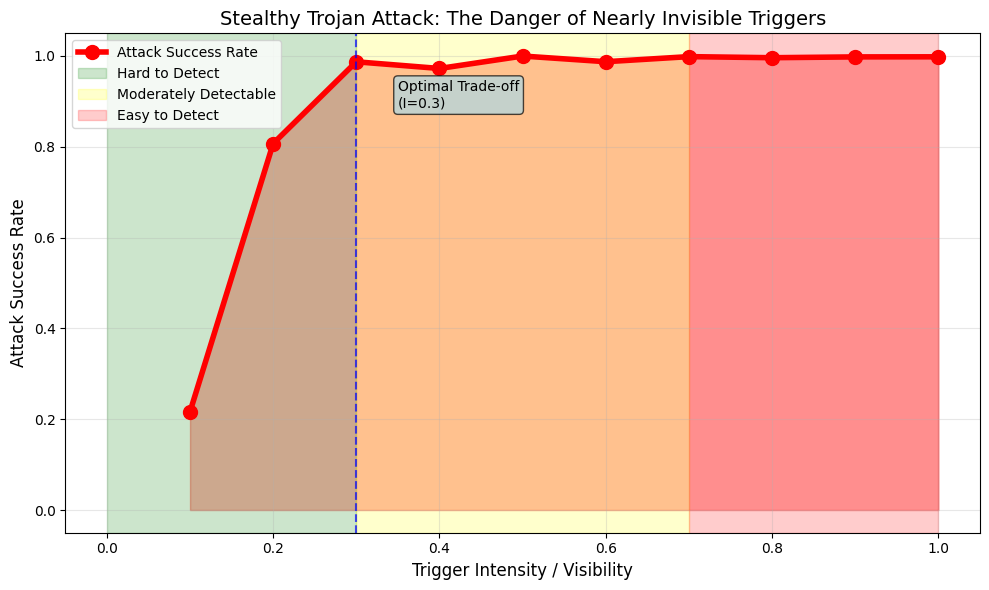


EXPERIMENT 2 COMPLETED: Stealthy vs Visible Triggers Analyzed!


In [26]:
# Final summary plot
plt.figure(figsize=(10, 6))

# Create a comprehensive visualization
intensities_plot = [r['intensity'] for r in results]
success_rates = [r['success_rate'] for r in results]
stealth_scores = [1 - r['intensity'] for r in results]

plt.plot(intensities_plot, success_rates, 'ro-', linewidth=4, markersize=10, label='Attack Success Rate')
plt.fill_between(intensities_plot, success_rates, alpha=0.3, color='red')

# Add detectability regions
plt.axvspan(0.0, 0.3, alpha=0.2, color='green', label='Hard to Detect')
plt.axvspan(0.3, 0.7, alpha=0.2, color='yellow', label='Moderately Detectable')
plt.axvspan(0.7, 1.0, alpha=0.2, color='red', label='Easy to Detect')

plt.xlabel('Trigger Intensity / Visibility', fontsize=12)
plt.ylabel('Attack Success Rate', fontsize=12)
plt.title('Stealthy Trojan Attack: The Danger of Nearly Invisible Triggers', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Mark optimal point
plt.axvline(x=optimal_point['intensity'], color='blue', linestyle='--', alpha=0.7)
plt.text(optimal_point['intensity'] + 0.05, optimal_point['success_rate'] - 0.1,
         f'Optimal Trade-off\n(I={optimal_point["intensity"]})',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("EXPERIMENT 2 COMPLETED: Stealthy vs Visible Triggers Analyzed!")
print("="*70)